## Amazon Geoglyph Detection Using Machine Learning and Satellite Data

This notebook demonstrates an end-to-end pipeline for identifying potential geoglyph locations in the Brazilian Amazon using environmental data, clustering algorithms, and satellite imagery analysis.

### Introduction

These ancient structures, created by pre-Columbian civilizations, are often only visible from above and can provide crucial insights into historical human settlements. Our goal is to use machine learning to identify locations with similar environmental characteristics to known geoglyph sites.

### Public Sources 

1. Gregorio de Souza, Jonas & Schaan, Denise & Robinson, Mark & Barbosa, Antonia & Aragão, Luiz & Jr, Ben & Marimon, Beatriz & Brasil da Silva, Izaias & Khan, Salman & Nakahara, Francisco & Iriarte, Jose. (2018). Pre-Columbian earth-builders settled along the entire southern rim of the Amazon. Nature Communications. 9. 10.1038/s41467-018-03510-7.
2. [Archeoblog -> Known Geoglpyh Locations](https://www.jqjacobs.net/blog/)
3. [WorldClim Data](https://worldclim.org/data/worldclim21.html)
4. [HWSD Soil Data for the Amazon](https://www.fao.org/soils-portal/data-hub/soil-maps-and-databases/harmonized-world-soil-database-v20/en/)
5. [Brazilian Amazon Territorial Information](https://www.ibge.gov.br/geociencias/organizacao-do-territorio/estrutura-territorial/15819-amazonia-legal.html)
6. Sentinel-2 Imagery -> Google Earth Engine

### References Used

1. [Fnands-Major TOM embedding search](https://www.kaggle.com/code/fnands/major-tom-embedding-search)
2. [Paultimothymooney-How to use kaggle with openAI](https://www.kaggle.com/code/paultimothymooney/how-to-use-openai-models-on-kaggle)
3. [Paultimothymooney-How to query google earth engine using kaggle](https://www.kaggle.com/code/paultimothymooney/how-to-query-google-earth-engine-data-using-kaggle)



In [3]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 56.9 MB/s eta 0:00:00:00:0100:01


In [4]:
import numpy as np
import pandas as pd
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box, Point
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler
import hdbscan
import seaborn as sns
import ee
import io
from io import BytesIO
import os
import urllib.request
from kaggle_secrets import UserSecretsClient
from PIL import Image
import requests
import base64

In [ ]:
amazon = gpd.read_file('/kaggle/input/braamazonshapefile/Limites_Amazonia_Legal_2022.shp')

amazon.plot()
plt.show()

#### Our initial idea was to divide the Brazilian Amazon into grids of areas 36sq.km, and then find the centroid of each of these grids. Then for each location, we would extract the data - (bioclimatic variables, soil data, elevation, etc.) and then compare them with the properties of known geoglyphs

In [ ]:
amazon = amazon.to_crs("EPSG:5880")  
cell_size = 6000 

minx, miny, maxx, maxy = amazon.total_bounds
cols = list(range(int(minx), int(maxx), cell_size))
rows = list(range(int(miny), int(maxy), cell_size))

grid_cells = []
for x in cols:
    for y in rows:
        grid_cells.append(box(x, y, x+cell_size, y+cell_size))

#### Later on, we realised that centroids of 36 sq.km cannot help in accurately judging weather a particular location could be a potential site with a geoglyph. So we went into each grid, and found coordinates of points that are 500 metres away from each other. This resulted in 17 million coordinates across Brazilian Amazon. So, we take the amazon_centroids.shp file generated by the previous code and generate a new file called amazon_500m_samples.shp.

In [ ]:
grid = gpd.GeoDataFrame({'geometry': grid_cells}, crs=amazon.crs)
amazon_grid = gpd.overlay(grid, amazon, how='intersection')
amazon_grid.to_file('/kaggle/working/amazon_grid.shp')
print(f"Generated {len(amazon_grid)} grid cells")

In [ ]:
new_amazon = gpd.read_file('/kaggle/working/amazon_grid.shp')
print(new_amazon.head())
fig, ax = plt.subplots(figsize=(8,8))
new_amazon.boundary.plot(ax=ax, linewidth=0.5, edgecolor='black')
ax.set_title("Brazilian Amazon Grid Boundaries")
plt.show()
new_amazon.plot()
plt.show()

In [ ]:
sample_pts = []
step = 500  

for idx, row in new_amazon.iterrows():
    poly = row.geometry
    minx, miny, maxx, maxy = poly.bounds
    
    xs = np.arange(minx, maxx + step, step)
    ys = np.arange(miny, maxy + step, step)
    
    for x in xs:
        for y in ys:
            pt = Point(x, y)
            if poly.contains(pt):
                sample_pts.append(pt)
pts_gdf = gpd.GeoDataFrame(geometry=sample_pts, crs=grid.crs)

pts_gdf.to_file('/kaggle/working/amazon_500m_samples.shp')

In [ ]:
am = gpd.read_file('/kaggle/working/amazon_500m_samples.shp')
am.to_crs("epsg:4326", inplace=True)

am.to_file('/kaggle/working/amazon_500m_latlon.shp')

In [ ]:
pts = gpd.read_file('/kaggle/working/amazon_500m_latlon.shp')

pts['longitude'] = pts.geometry.x
pts['latitude']  = pts.geometry.y

vars_to_keep = ['longitude', 'latitude']
df = pts[vars_to_keep].copy()

df = df.replace({-9999: pd.NA}).dropna()

df.to_csv('amazon_500m_features.csv', index=False)

This code deals with extracting the bioclimatic variables from the worldclim dataset. It also extracts elevation data from a dataset I found on kaggle. So we are taking 7 tif files from the worldclim dataset and 1 tif file from the dataset on kaggle. Each tif file represents a variable, like elevation, temperature seasonality, etc. We extract data for each of these variables by feeding the coordinates that we found earlier.

In [ ]:
df = pd.read_csv('code/amazon_500m_features.csv')
coords = list(zip(df.longitude, df.latitude))

rasters = {
    'temp_seasonality': '/kaggle/input/worldclim-3457121719-elevation/wc2.1_5m_bio_4.tif',
    'temp_annual_range': '/kaggle/input/worldclim-3457121719-elevation/wc2.1_5m_bio_7.tif',
    'precip_driest_quarter': '/kaggle/input/worldclim-3457121719-elevation/wc2.1_5m_bio_17.tif',
    'max_temp_warmest_month': '/kaggle/input/worldclim-3457121719-elevation/wc2.1_5m_bio_5.tif',
    'annual_precipitation': '/kaggle/input/worldclim-3457121719-elevation/wc2.1_5m_bio_12.tif',
    'precip_coldest_quarter': '/kaggle/input/worldclim-3457121719-elevation/wc2.1_5m_bio_19.tif',
    'isothermality': '/kaggle/input/worldclim-3457121719-elevation/wc2.1_5m_bio_3.tif',
    'elevation': '/kaggle/input/worldclim-3457121719-elevation/elevation_south_america.tif'
} 

for var_name, path in rasters.items():
    with rasterio.open(path) as src:
        vals = [val[0] for val in src.sample(coords)]
        df[var_name] = vals


df.to_csv('/kaggle/working/amazon_500m_with_worldclim_vars.csv', index=False)

To get the remaining two variables, sand fraction and gravel content, we used the hwsd dataset. This was a bit tricky. Firstly, the files downloaded from here is a bil file, not a tif file and that too, in a different crs than EPSG:4326. So first, we had to write a script to convert the bil file's crs and store it in a tif file. Another tricky part is, when we enter a pair of coordinates, we dont get data for a particular variable, we only get a mu_key(map unit key), which is a primary column in an associated database called hwsd.csv. This csv file contains several soil data variables and the value for each mu_key, which is the primary column. 

This extracts soil data for each coordinate by extracting the corresponding mu_key from the tif file and then using this mu_key in the hwsd_data.csv to get the required variables - soil fraction and gravel content. Another tricky part here is that in the hwsd_data.csv, there are multiple rows with the same mu_key, so we take the average of values for a particular mu_key. This code edits the amazon_500m_worldclim_vars.csv file generated by the extracting_data.py file earlier. After adding the required columns, it writes everything TO amazon_unknown_geoglyph_points.csv

In [ ]:
src_path = '/kaggle/input/hwsd-database/HWSD2.bil'
dst_path = '/kaggle/working/HWSD2_Map_unit_4326.tif'
dst_crs  = 'EPSG:4326'

with rasterio.open(src_path) as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs,
        src.width, src.height,
        *src.bounds
    )
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height,
        'driver': 'GTiff'
    })

    # Create the destination file and reproject each band
    with rasterio.open(dst_path, 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest
            )

print(f"Reprojected to {dst_path} in {dst_crs}.")

In [ ]:
df = pd.read_csv('/kaggle/working/amazon_500m_with_worldclim_vars.csv')
coords = list(zip(df.longitude, df.latitude))
with rasterio.open('/kaggle/working/HWSD2_Map_unit_4326.tif') as src:
    df['MU_GLOBAL'] = [val[0] for val in src.sample(coords)]

soil_raw = pd.read_csv(
    '/kaggle/input/hwsd-database/HWSD_DATA.csv',
    usecols=['MU_GLOBAL','T_SAND','T_GRAVEL']
)

soil = (
    soil_raw
    .dropna(subset=['T_SAND','T_GRAVEL'])
    .groupby('MU_GLOBAL', as_index=False)
    .agg({
        'T_SAND':   'mean',
        'T_GRAVEL': 'mean'
    })
)

print(f"Collapsed from {len(soil_raw)} to {len(soil)} unique MU_GLOBAL units")

df = df.merge(
    soil,
    how='left',
    on='MU_GLOBAL',
    validate='many_to_one'
)

df = df.rename(columns={
    'T_SAND':   'sand_frac_pct',
    'T_GRAVEL': 'gravel_frac_pct'
})

df.to_csv('/kaggle/working/amazon_unknown_geoglyph_data.csv', index=False)
print("Done—rows:", len(df))

In [ ]:
df = pd.read_csv('/kaggle/input/amazon-known-geoglyph-coords/amazon_geoglyph_coords.csv')
coords = list(zip(df.longitude, df.latitude))

rasters = {
        'temp_seasonality': '/kaggle/input/worldclim-3457121719-elevation/wc2.1_5m_bio_4.tif',
    'temp_annual_range': '/kaggle/input/worldclim-3457121719-elevation/wc2.1_5m_bio_7.tif',
    'precip_driest_quarter': '/kaggle/input/worldclim-3457121719-elevation/wc2.1_5m_bio_17.tif',
    'max_temp_warmest_month': '/kaggle/input/worldclim-3457121719-elevation/wc2.1_5m_bio_5.tif',
    'annual_precipitation': '/kaggle/input/worldclim-3457121719-elevation/wc2.1_5m_bio_12.tif',
    'precip_coldest_quarter': '/kaggle/input/worldclim-3457121719-elevation/wc2.1_5m_bio_19.tif',
    'isothermality': '/kaggle/input/worldclim-3457121719-elevation/wc2.1_5m_bio_3.tif',
    'elevation': '/kaggle/input/worldclim-3457121719-elevation/elevation_south_america.tif'

}

for var_name, path in rasters.items():
    with rasterio.open(path) as src:
        # sample returns a generator of 1-element arrays
        vals = [val[0] for val in src.sample(coords)]
        df[var_name] = vals

df.to_csv('/kaggle/working/amazon_known_geoglyph_data.csv', index=False)
print("Done—wrote amazon_known_geoglyph_data.csv with shape", df.shape)

In [ ]:
df = pd.read_csv('/kaggle/working/amazon_known_geoglyph_data.csv')
coords = list(zip(df.longitude, df.latitude))

with rasterio.open('/kaggle/working/HWSD2_Map_unit_4326.tif') as src:
    df['MU_GLOBAL'] = [val[0] for val in src.sample(coords)]

soil_raw = pd.read_csv(
    'code/HWSD_DATA.csv',
    usecols=['MU_GLOBAL','T_SAND','T_GRAVEL']
)

soil = (
    soil_raw
    .dropna(subset=['T_SAND','T_GRAVEL'])
    .groupby('MU_GLOBAL', as_index=False)
    .agg({
        'T_SAND':   'mean',
        'T_GRAVEL': 'mean'
    })
)

print(f"Collapsed from {len(soil_raw)} to {len(soil)} unique MU_GLOBAL units")

df = df.merge(
    soil,
    how='left',
    on='MU_GLOBAL',
    validate='many_to_one'
)

df = df.rename(columns={
    'T_SAND':   'sand_frac_pct',
    'T_GRAVEL': 'gravel_frac_pct'
})

df.to_csv('/kaggle/working/amazon_known_geoglyph_data.csv', index=False)
print("Done—rows:", len(df))

Now we have two CSV files:

1. amazon_known_geoglyph_data.csv - with data about locations that are known to be geoglyphs
2. amazon_unknown_geogleyph_data.csv - with data about all the other locations in Brazilian Amazon.

 We decided to run a clustering algorithm and report all those points that fall in the same clusters as the coordinates of known geoglyphs. We chose to go with hdbscan because our pca revealed non complex patterns. Also, with over 17 million rows, we decided to reduce the area of study from the entirety of Brazilian Aamazon to the state of Amazonas in Brazil and a few surrounding areas, which resulted in around 7.5 million rows.

In [ ]:
df_all = pd.read_csv('/kaggle/working/amazon_unknown_geoglyph_data.csv')
df_all['is_geoglyph'] = 0

df_known = pd.read_csv('/kaggle/working/amazon_known_geoglyph_data.csv')
df_known['is_geoglyph'] = 1

df = pd.concat([df_all, df_known], ignore_index=True)

In [ ]:
features = [
    'temp_seasonality',
    'temp_annual_range',
    'precip_driest_quarter',
    'max_temp_warmest_month',
    'annual_precipitation',
    'precip_coldest_quarter',
    'isothermality',
    'elevation',
    'sand_frac_pct',
    'gravel_frac_pct'
]
X = df[features].values

imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)
pca = PCA(n_components=2, random_state=0)
X_2d = pca.fit_transform(X_scaled)

mask = (
    (np.abs(X_2d[:,0]) < 5 * X_2d[:,0].std()) &
    (np.abs(X_2d[:,1]) < 5 * X_2d[:,1].std())
)
X_2d = X_2d[mask]
df = df[mask]

In [ ]:
for i, comp in enumerate(pca.components_):
    print(f"\nPC{i+1} loadings:")
    for feat, loading in zip(features, comp):
        print(f"  {feat}: {loading:.2f}")

n_samples = X_2d.shape[0]
sub_idx = np.random.choice(n_samples, size=200_000, replace=False)

X_sub = X_2d[sub_idx]
y_sub = df['is_geoglyph'].values[sub_idx].astype(bool)

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(
    X_sub[~y_sub, 0], X_sub[~y_sub, 1],
    s=2, alpha=0.3, label='Grid points'
)
plt.scatter(
    X_sub[y_sub, 0], X_sub[y_sub, 1],
    s=8, alpha=0.8, color='red', label='Known geoglyphs'
)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('2D PCA of Environmental Features')
plt.legend(markerscale=4)
plt.show()

In [ ]:
df = pd.read_csv('/kaggle/working/amazon_unknown_geoglyph_data.csv')

mask = (
    (df.longitude >= -72) &
    (df.longitude <= -55) &
    (df.latitude  >= -16) &
    (df.latitude  <=   -2)
)

df2 = df[mask].reset_index(drop=True)

print("Length of original DataFrame:", len(df))
print("Length of reduced DataFrame:", len(df2))

df2.to_csv('/kaggle/working/amazon_reduced_unknown_geoglyph_data.csv', index=False)

In [ ]:
MIN_CLUSTER_SIZE = 200   
MIN_SAMPLES      = 20     
PROB_THRESHOLD   = 0.7

In [ ]:
df_unknown = pd.read_csv('/kaggle/working/amazon_reduced_unknown_geoglyph_data.csv')
df_unknown['is_geoglyph'] = 0

df_known = pd.read_csv('/kaggle/working/amazon_known_geoglyph_data.csv')
df_known['is_geoglyph'] = 1

df = pd.concat([df_unknown, df_known], ignore_index=True)

features = [
    'temp_seasonality',
    'temp_annual_range',
    'precip_driest_quarter',
    'max_temp_warmest_month',
    'annual_precipitation',
    'precip_coldest_quarter',
    'isothermality',
    'elevation',
    'sand_frac_pct',
    'gravel_frac_pct'
]

X = df[features].values
X = SimpleImputer(strategy='mean').fit_transform(X)
X = StandardScaler().fit_transform(X)

In [ ]:
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=MIN_CLUSTER_SIZE,
    min_samples=MIN_SAMPLES,
    prediction_data=True,
    core_dist_n_jobs=4
)
labels       = clusterer.fit_predict(X)
probabilities = clusterer.probabilities_

df['hdbscan_label']       = labels
df['hdbscan_probability'] = probabilities

In [ ]:
known_labels = set(df.loc[df.is_geoglyph == 1, 'hdbscan_label'])
known_labels.discard(-1)   # ignore noise if any

In [ ]:
mask_candidates = (
    (df.is_geoglyph == 0) &
    (df.hdbscan_label.isin(known_labels)) &
    (df.hdbscan_probability >= PROB_THRESHOLD)
)
df_candidates = df.loc[mask_candidates].copy()

In [ ]:
cols_to_keep = ['longitude', 'latitude'] + features
df_candidates[cols_to_keep].to_csv(
    '/kaggle/working/amazon_high_priority_candidates.csv',
    index=False
)

print(f"Clusters containing known sites: {sorted(known_labels)}")
print(f"Total unknown points retained: {len(df_candidates)}")

In [5]:
candidate_points = pd.read_csv("/kaggle/input/final-candidates/amazon_high_priority_candidates (1).csv")
geoglyphs_df = pd.read_csv('/kaggle/input/amazon-known-geoglyph-coords/amazon_geoglyph_coords.csv')

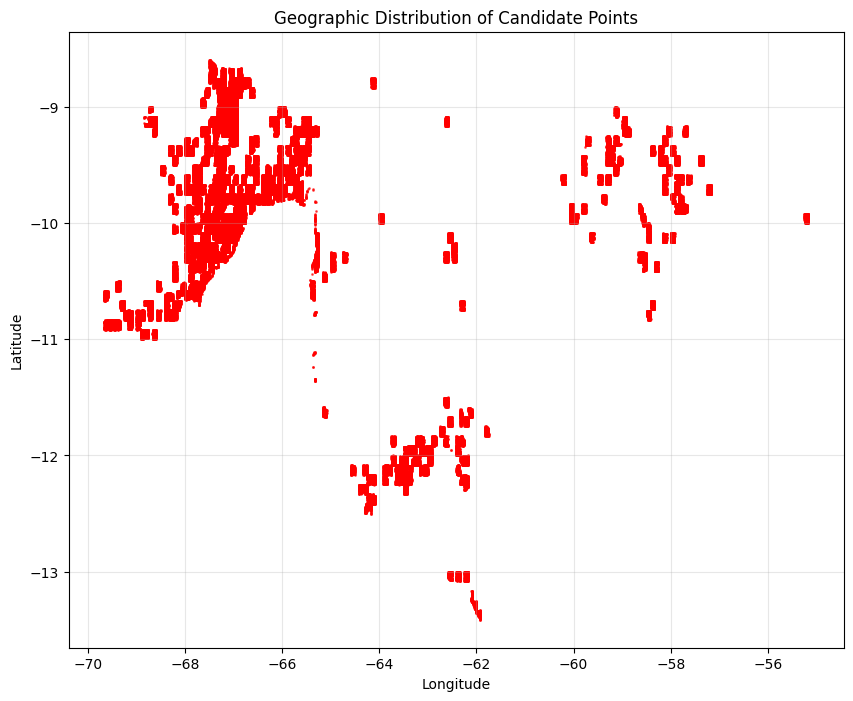

In [11]:
plt.figure(figsize=(10, 8))
plt.scatter(candidate_points['longitude'], candidate_points['latitude'], 
           s=1, alpha=0.6, c='red')
plt.title('Geographic Distribution of Candidate Points')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True, alpha=0.3)
plt.show()

In [20]:
def calculate_priority_scores(df):
    scaler = MinMaxScaler()
    df_copy = df.copy()
    
    # Define weights based on research paper's percent contribution
    # Using available variables from your dataset that match the paper
    feature_weights = {
        'precip_coldest_quarter': 32.2,      # Highest importance
        'precip_driest_quarter': 13.9,       # Second highest
        'temp_seasonality': 11.7,            # Third highest
        'elevation': 7.7,
        'annual_precipitation': 5.3,
        'max_temp_warmest_month': 5.0,
        'temp_annual_range': 2.5,
        'isothermality': 1.8,
        'gravel_frac_pct': 1.4,             # Gravel content
        'sand_frac_pct': 0.6                # Sand fraction (lower importance)
    }
    
    # Normalize weights to sum to 1
    total_weight = sum(feature_weights.values())
    normalized_weights = {k: v/total_weight for k, v in feature_weights.items()}
    
    # Scale features
    available_features = [f for f in feature_weights.keys() if f in df_copy.columns]
    scaled_data = scaler.fit_transform(df_copy[available_features])
    
    # Calculate individual component scores
    component_scores = {}
    
    for i, feature in enumerate(available_features):
        scaled_values = scaled_data[:, i]
        
        if feature == 'precip_coldest_quarter':
            # Higher precipitation in cold quarter is better (water availability)
            component_scores[feature] = scaled_values
            
        elif feature == 'precip_driest_quarter':
            # Moderate values preferred (not too dry, not too wet)
            component_scores[feature] = 1 - np.abs(scaled_values - 0.4) * 2
            
        elif feature == 'temp_seasonality':
            # Moderate seasonality preferred (stable but not monotonous)
            component_scores[feature] = 1 - np.abs(scaled_values - 0.5) * 2
            
        elif feature == 'elevation':
            # Higher elevation preferred (drainage, visibility)
            component_scores[feature] = scaled_values
            
        elif feature == 'annual_precipitation':
            # Moderate to high precipitation preferred
            component_scores[feature] = 1 - np.abs(scaled_values - 0.6) * 2
            
        elif feature == 'max_temp_warmest_month':
            # Moderate temperatures preferred (not too extreme)
            component_scores[feature] = 1 - np.abs(scaled_values - 0.4) * 2
            
        elif feature == 'temp_annual_range':
            # Lower temperature range preferred (more stable)
            component_scores[feature] = 1 - scaled_values
            
        elif feature == 'isothermality':
            # Higher isothermality preferred (temperature stability)
            component_scores[feature] = scaled_values
            
        elif feature == 'gravel_frac_pct':
            # Lower gravel content preferred (easier construction)
            component_scores[feature] = 1 - scaled_values
            
        elif feature == 'sand_frac_pct':
            # Moderate sand content preferred (good drainage but stable)
            component_scores[feature] = 1 - np.abs(scaled_values - 0.6) * 2
    
    # Calculate weighted priority score
    weighted_score = np.zeros(len(df_copy))
    
    for feature in available_features:
        weight = normalized_weights[feature]
        score = component_scores[feature]
        weighted_score += weight * score
        
        # Store individual component scores for analysis
        df_copy[f'{feature}_score'] = score
        df_copy[f'{feature}_weight'] = weight
    
    df_copy['priority_score'] = weighted_score
    
    # Add feature importance summary
    df_copy['top_3_features'] = 'precip_coldest_quarter, precip_driest_quarter, temp_seasonality'
    
    return df_copy


In [21]:
candidate_points_scored = calculate_priority_scores(candidate_points)
top_candidates = candidate_points_scored.nlargest(1000, 'priority_score')

print(f"Top 1000 candidate locations identified for priority investigation")
print(f"Priority score range: {top_candidates['priority_score'].min():.3f} to {top_candidates['priority_score'].max():.3f}")

Top 1000 candidate locations identified for priority investigation
Priority score range: 0.569 to 0.671


In [22]:
coords = candidate_points[['longitude', 'latitude']].values
dbscan = DBSCAN(eps=0.01, min_samples=10)
spatial_clusters = dbscan.fit_predict(coords)

candidate_points['spatial_cluster'] = spatial_clusters

n_clusters = len(set(spatial_clusters)) - (1 if -1 in spatial_clusters else 0)
n_noise = list(spatial_clusters).count(-1)

print(f"Spatial Analysis Results:")
print(f"Number of spatial clusters: {n_clusters}")
print(f"Number of isolated points: {n_noise}")
print(f"Points in clusters: {len(candidate_points) - n_noise}")

Spatial Analysis Results:
Number of spatial clusters: 257
Number of isolated points: 3191
Points in clusters: 104292


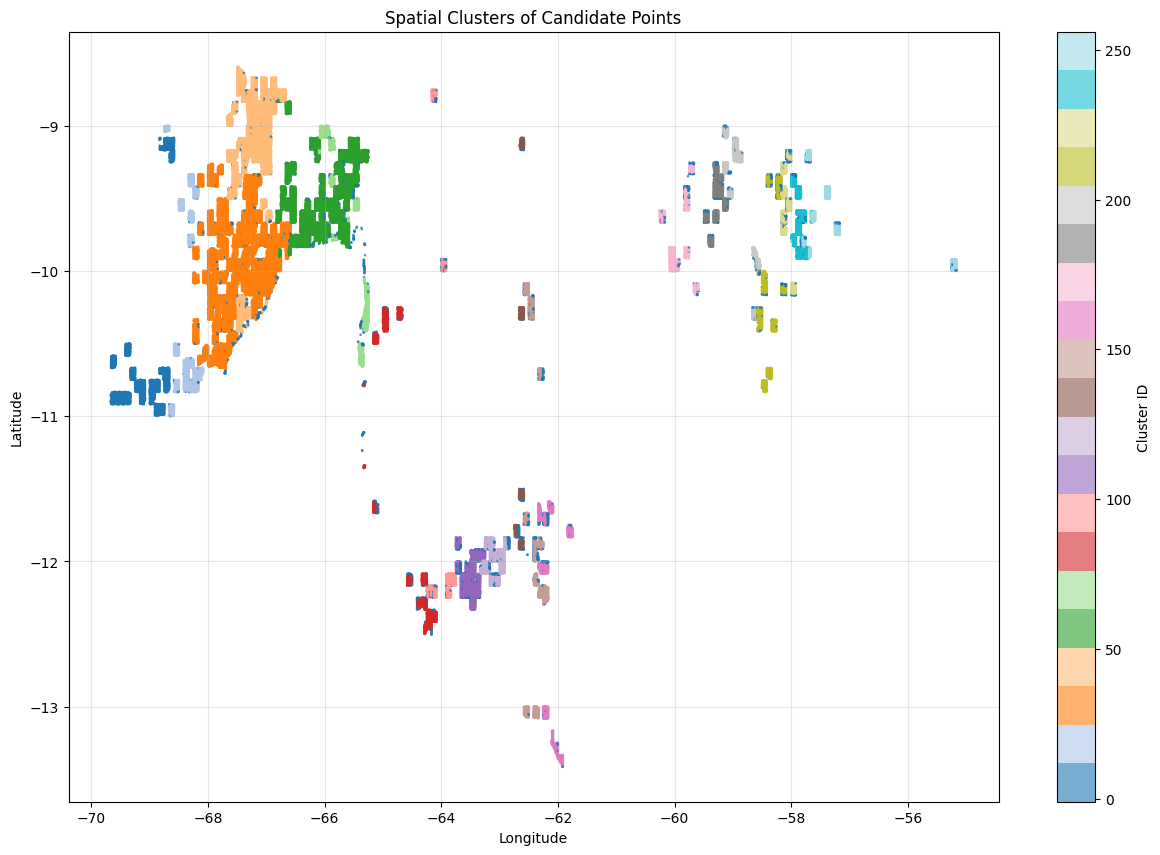

In [23]:
plt.figure(figsize=(15, 10))
scatter = plt.scatter(candidate_points['longitude'], candidate_points['latitude'], 
                     c=candidate_points['spatial_cluster'], s=1, alpha=0.6, cmap='tab20')
plt.title('Spatial Clusters of Candidate Points')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(scatter, label='Cluster ID')
plt.grid(True, alpha=0.3)
plt.show()

In [24]:
print("Available columns:", candidate_points_scored.columns.tolist())
base_columns = ['longitude', 'latitude', 'priority_score', 'elevation', 'temp_seasonality', 
                'precip_driest_quarter', 'annual_precipitation']

available_columns = [col for col in base_columns if col in candidate_points_scored.columns]
print("Using columns:", available_columns)

priority_locations = candidate_points_scored.nlargest(500, 'priority_score')[available_columns].reset_index(drop=True)

Available columns: ['longitude', 'latitude', 'temp_seasonality', 'temp_annual_range', 'precip_driest_quarter', 'max_temp_warmest_month', 'annual_precipitation', 'precip_coldest_quarter', 'isothermality', 'elevation', 'sand_frac_pct', 'gravel_frac_pct', 'spatial_cluster', 'precip_coldest_quarter_score', 'precip_coldest_quarter_weight', 'precip_driest_quarter_score', 'precip_driest_quarter_weight', 'temp_seasonality_score', 'temp_seasonality_weight', 'elevation_score', 'elevation_weight', 'annual_precipitation_score', 'annual_precipitation_weight', 'max_temp_warmest_month_score', 'max_temp_warmest_month_weight', 'temp_annual_range_score', 'temp_annual_range_weight', 'isothermality_score', 'isothermality_weight', 'gravel_frac_pct_score', 'gravel_frac_pct_weight', 'sand_frac_pct_score', 'sand_frac_pct_weight', 'priority_score', 'top_3_features']
Using columns: ['longitude', 'latitude', 'priority_score', 'elevation', 'temp_seasonality', 'precip_driest_quarter', 'annual_precipitation']


In [25]:
coords = priority_locations[['longitude', 'latitude']].values
dbscan = DBSCAN(eps=0.01, min_samples=5)  # ~1km clusters
spatial_clusters = dbscan.fit_predict(coords)
priority_locations['spatial_cluster'] = spatial_clusters[3]

priority_locations['rank'] = range(1, len(priority_locations) + 1)

priority_locations.to_csv('priority_geoglyph_candidates.csv', index=False)

print("Analysis Summary:")
print(f"Top {len(priority_locations)} priority locations created")
print(f"Columns included: {priority_locations.columns.tolist()}")

print("\nTop 10 Priority Locations:")
display_columns = ['rank', 'longitude', 'latitude', 'priority_score', 'elevation']
available_display_columns = [col for col in display_columns if col in priority_locations.columns]
print(priority_locations[available_display_columns].head(10))

Analysis Summary:
Top 500 priority locations created
Columns included: ['longitude', 'latitude', 'priority_score', 'elevation', 'temp_seasonality', 'precip_driest_quarter', 'annual_precipitation', 'spatial_cluster', 'rank']

Top 10 Priority Locations:
   rank  longitude  latitude  priority_score  elevation
0     1 -55.230905 -9.978988        0.671132        320
1     2 -55.230888 -9.974469        0.671132        320
2     3 -55.226345 -9.979005        0.671132        320
3     4 -55.226328 -9.974486        0.671132        320
4     5 -55.203429 -9.947452        0.671132        320
5     6 -55.203412 -9.942932        0.671132        320
6     7 -55.198869 -9.947468        0.671132        320
7     8 -55.198852 -9.942949        0.671132        320
8     9 -55.240025 -9.978955        0.670694        318
9    10 -55.240008 -9.974435        0.670694        318


/tmp/ipykernel_35/399412184.py:3: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


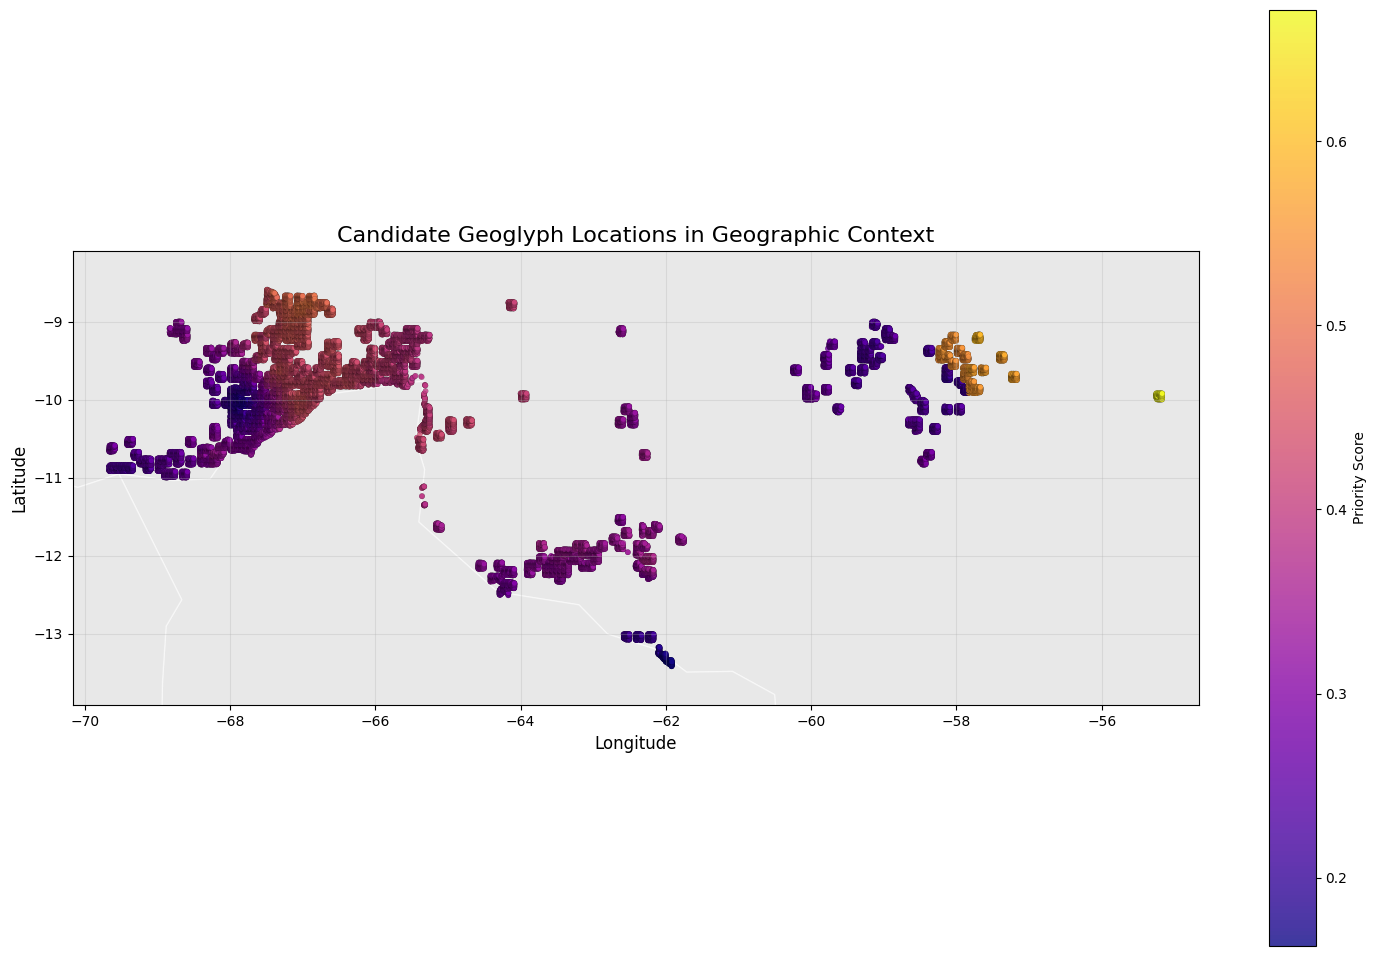

In [26]:
fig, ax = plt.subplots(figsize=(15, 12))
try:
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    
    south_america = world[world['continent'] == 'South America']
    south_america.plot(ax=ax, color='lightgray', edgecolor='white', alpha=0.5)
except:
    print("GeoPandas world data not available, creating basic plot")

scatter = ax.scatter(candidate_points_scored['longitude'], 
                    candidate_points_scored['latitude'], 
                    c=candidate_points_scored['priority_score'], 
                    cmap='plasma', s=15, alpha=0.8, edgecolor='black', linewidth=0.1)

ax.set_xlim(candidate_points_scored['longitude'].min() - 0.5, 
           candidate_points_scored['longitude'].max() + 0.5)
ax.set_ylim(candidate_points_scored['latitude'].min() - 0.5, 
           candidate_points_scored['latitude'].max() + 0.5)

plt.colorbar(scatter, ax=ax, label='Priority Score', shrink=0.8)
ax.set_title('Candidate Geoglyph Locations in Geographic Context', fontsize=16)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [27]:
def create_geodataframe(df, lon_col='longitude', lat_col='latitude'):
    df['geometry'] = df.apply(lambda row: Point(row[lon_col], row[lat_col]), axis=1)
    gdf = gpd.GeoDataFrame(df, geometry='geometry')
    gdf.set_crs(epsg=4326, inplace=True)
    return gdf

In [28]:
candidate_gdf = create_geodataframe(candidate_points_scored)
geoglyphs_gdf = create_geodataframe(geoglyphs_df)
matched_points = gpd.sjoin(candidate_gdf, geoglyphs_gdf, how='inner', predicate='intersects')
num_matches = len(matched_points)
num_candidates = len(candidate_gdf)
num_geoglyphs = len(geoglyphs_gdf)
percent_match = (num_matches / num_candidates) * 100 if num_candidates > 0 else 0

print(f"Exact Match Results:")
print(f"Candidate points: {num_candidates:,}")
print(f"Known geoglyphs: {num_geoglyphs:,}")
print(f"Exact matches: {num_matches}")
print(f"Percentage of candidates that are known geoglyphs: {percent_match:.2f}%")

Exact Match Results:
Candidate points: 107,483
Known geoglyphs: 1,698
Exact matches: 0
Percentage of candidates that are known geoglyphs: 0.00%


In [29]:
def load_secret(name):
    """Loads secret from Colab/Kaggle."""

    if 'KAGGLE_KERNEL_RUN_TYPE' in os.environ:
        try:
            from kaggle_secrets import UserSecretsClient
            return UserSecretsClient().get_secret(name)
        except Exception:
            pass 
    else:
        try:
            from google.colab import userdata
            return userdata.get(name)
        except Exception: 
            pass

    return 'Secret not found'

In [33]:
import ee

service_account = load_secret('SERVICE_ACCOUNT')
key_file = load_secret('KEY_FILE')

ee_creds = ee.ServiceAccountCredentials(service_account, key_file)
ee.Initialize(ee_creds)

In [48]:
def download_gee_image(lat, lon, filename):
    point_geom = ee.Geometry.Point([lon, lat])
    collection = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
        .filterBounds(point_geom) \
        .filterDate('2023-01-01', '2024-06-26') \
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)) \
        .sort('system:time_start', False)
    image = collection.first()
    url = image.getThumbURL({
        'region': point_geom.buffer(500).bounds().getInfo()['coordinates'],
        'dimensions': 512,
        'format': 'png',
        'min': 0,
        'max': 3000,
        'bands': ['B4', 'B3', 'B2']
    })
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img.save(filename)
    return filename


In [47]:
image_files = []
for idx, row in priority_locations.head(3).iterrows():
    fname = f"candidate_{idx+1}.png"
    download_gee_image(row['latitude'], row['longitude'], fname)
    image_files.append(fname)

In [49]:
OPENAI_API_KEY = load_secret("OPENAI_KEY")

def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")

def analyze_image_with_gpt(image_path, prompt):
    base64_image = encode_image(image_path)
    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {OPENAI_API_KEY}"
    }
    payload = {
        "model": "gpt-4o",
        "messages": [
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": prompt},
                    {"type": "image_url", "image_url": {"url": f"data:image/png;base64,{base64_image}"}}
                ]
            }
        ],
        "max_tokens": 300
    }
    response = requests.post(
        "https://api.openai.com/v1/chat/completions",
        headers=headers, json=payload
    )
    return response.json()

In [50]:
prompt = (
    "You are a world-renowned expert in archaeological remote sensing and Amazonian geoglyph detection with 20+ years of field experience. "
    "Your task is to conduct a comprehensive analysis of this high-resolution satellite image for potential pre-Columbian earthwork sites.\n\n"
    
    "SEARCH CRITERIA - Look specifically for:\n"
    "• Geometric earthworks: Perfect or near-perfect circles, squares, rectangles, octagons, or complex geometric combinations\n"
    "• Linear features: Straight ditches, embankments, causeways, or raised walkways extending 50+ meters\n"
    "• Concentric patterns: Multiple rings or nested geometric shapes\n"
    "• Unusual clearings: Circular or geometric forest clearings that don't match typical agricultural patterns\n"
    "• Vegetation anomalies: Distinct color/texture differences indicating subsurface archaeological features\n"
    "• Shadow patterns: Subtle elevation changes creating geometric shadow lines\n"
    "• Water management features: Ancient canals, reservoirs, or drainage systems with geometric layouts\n\n"
    
    "ANALYSIS FRAMEWORK:\n"
    "1. GEOMETRIC ASSESSMENT: Evaluate regularity, symmetry, and intentional design vs. natural formations\n"
    "2. SCALE ANALYSIS: Measure approximate dimensions (geoglyphs typically 50-300 meters diameter)\n"
    "3. CONTEXT EVALUATION: Consider surrounding landscape, modern disturbances, and preservation state\n"
    "4. FEATURE CLARITY: Assess visibility and definition of potential archaeological elements\n\n"
    
    "REPORTING REQUIREMENTS:\n"
    "• PROBABILITY SCORE: Provide a precise percentage (0-100%) for geoglyph likelihood\n"
    "• FEATURE DESCRIPTION: Detail all observed geometric patterns, dimensions, and archaeological indicators\n"
    "• PRESERVATION STATE: Comment on site condition and any modern impacts (deforestation, agriculture, development)\n"
    "• COMPARATIVE ANALYSIS: Reference similarity to known geoglyph types (Acre, Rondônia, or Amazonas styles)\n"
    "• CONFIDENCE LEVEL: Rate your certainty in the assessment (High/Medium/Low)\n"
    "• FINAL RECOMMENDATION: Choose ONE - Investigate (field survey recommended), Marginal (requires additional imagery), or Reject (natural formation)\n\n"
    
    "Consider that authentic geoglyphs often show: perfect geometric precision, intentional landscape modification, "
    "integration with natural topography, and evidence of ancient construction techniques. "
    "Be thorough but decisive in your professional assessment."
)


In [51]:
for fname in image_files:
    print(f"\n--- Analysis for {fname} ---")
    result = analyze_image_with_gpt(fname, prompt)
    print(result['choices'][0]['message']['content'])


--- Analysis for candidate_1.png ---
To analyze the satellite image for potential Amazonian geoglyphs, let's examine key features:

### Key Features Observed

1. **Geometric Patterns**: The presence of any noticeable geometric shapes like circles, squares, or patterns that align with known geoglyph structures.

2. **Earthworks**: Signs of embankments or ditches, typically appearing as linear, elevated, or depressed features within the landscape.

3. **Unusual Clearings**: Areas that appear differently from the surrounding vegetation—often symmetrical or unusually structured.

### Analysis

- **Geometric Patterns**: There is a lack of clear geometric shapes or coherent patterns that resemble known geoglyph forms.
- **Earthworks**: The image does not show distinct embankments or ditches that are typical markers of geoglyphs. The lines and divisions seem more like agricultural fields.
- **Unusual Clearings**: The clearings observed appear to align with farming activities, lacking symmetr